<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/Transfer_Learning_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Do simple transfer learning with TensorFlow Hub

In [1]:
# Import Required libraries
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [2]:
import numpy as np
import PIL.Image as Image

## Load Dataset

In [3]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteDBBVII/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


## Format images of same sizes

In [4]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Create Model

In [6]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [8]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [9]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [10]:
feature_extractor.trainable = False

## Attach a classifier head

In [11]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Compile and Train Model

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 40s 57ms/step - loss: 0.0991 - accuracy: 0.9614 - val_loss: 0.0339 - val_accuracy: 0.9884
Epoch 2/6
582/582 [==============================] - 36s 56ms/step - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.0431 - val_accuracy: 0.9865
Epoch 3/6
582/582 [==============================] - 37s 56ms/step - loss: 0.0261 - accuracy: 0.9908 - val_loss: 0.0313 - val_accuracy: 0.9901
Epoch 4/6
582/582 [==============================] - 36s 56ms/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0339 - val_accuracy: 0.9886
Epoch 5/6
582/582 [==============================] - 36s 56ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 0.0355 - val_accuracy: 0.9886
Epoch 6/6
582/582 [==============================] - 36s 56ms/step - loss: 0.0197 - accuracy: 0.9937 - val_loss: 0.0348 - val_accuracy: 0.9901


## Check the predictions

In [13]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

Run the image batch through the model and convert the indices to class names.

In [14]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat',
       'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog',
       'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'cat', 'dog', 'cat'], dtype='<U3')

In [15]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0]
Predicted labels:  [0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 0]


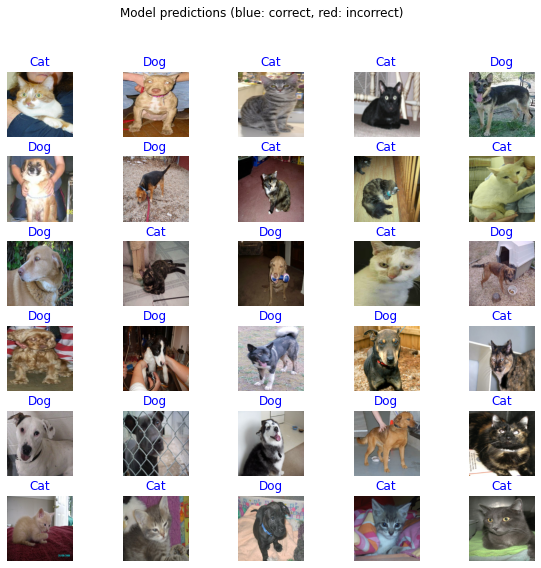

In [16]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")